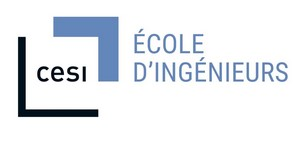

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter1)
* [1. Contraintes](#chapter2)
* [2. Configuration de l'environnement](#chapter3)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter4)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
* [4. Création du Modèle](#chapter5)
    * [4.1 Autoencodeur](#section_5_1)
    * [4.2 Implémentation du modèle](#section_5_2)
    * [4.3 Amélioration du modèle](#section_5_3)
* [5. Mesure de la performance](#chapter6)
* [6. Etude de cas](#chapiter7)
* [7. Conclusion](#chapiter8)

## Introduction <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitive dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précedente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous aborderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de Machine Learning.</div>

## 1. Contraintes <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixels, dans ce cas nous aurons 784 inputs dans notre réseau de neurones avec autant de dimensions, ce qui rend le traitement et l'analyse compliqués.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP (Analyse en Composantes Principale). Néanmoins cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure, nous pouvons alors nous tourner vers le t-SNE. Néanmoins, cet algorithme, bien que très efficace, ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter3"></a>

Tout comme dans le premier livrable nous devons préparer notre environnement de travail pour mener à bien notre projet. Par conséquent nous reviendrons sur les mêmes points qui ont été abordés précédemment qui sont : l'import des librairies Python et l'utilisation du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_3_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np
import pathlib
import keras.models as models
import keras.layers as layers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.initializers import orthogonal

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from PIL import Image

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_1"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia, avec Cuda installé, sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter4"></a>

<div style="text-align: justify"> Nous avons vu dans le premier livrable comment préparer notre jeu de données pour les algorithmes de deep learning. Néanmoins, nous devrons rajouter intentionellement du bruit sur nos images dans le but de pouvoir entrainer nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = pathlib.Path("Class")
image_h = 256
image_w = 256
batch_s = 9

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_4_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble, dit d'entraînement, permettra au modèle d'ajuster ses poids et par conséquent améliorer son débruitage. Le second nous permet d'évaluer la capacité du modèle à débruiter. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 10000 files belonging to 1 classes.
Using 8000 files for training.
Found 10000 files belonging to 1 classes.
Using 2000 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_4_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [5]:
#process image 
def preprocess(data, is_batch = True):
    batch_size = len(data) if is_batch else 1
    data = np.array(data, dtype=np.float32) #conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (batch_size, image_h, image_w, 3))# redimensionnement de l'array
    return data

#Bruitage de l'image
def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)#Normalization des données après le bruitage
    
#Sépare les features des labels 
def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train) 
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issues de notre dataset ont bien été bruitées.

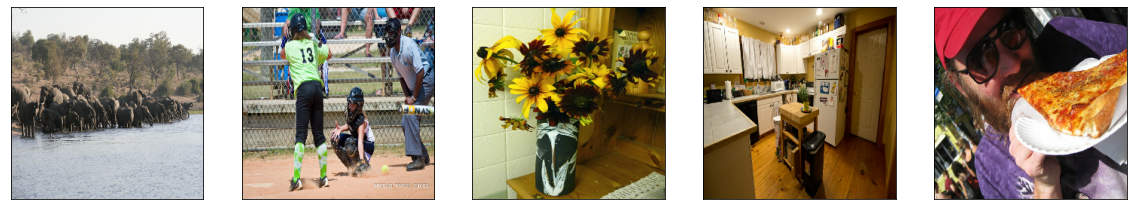

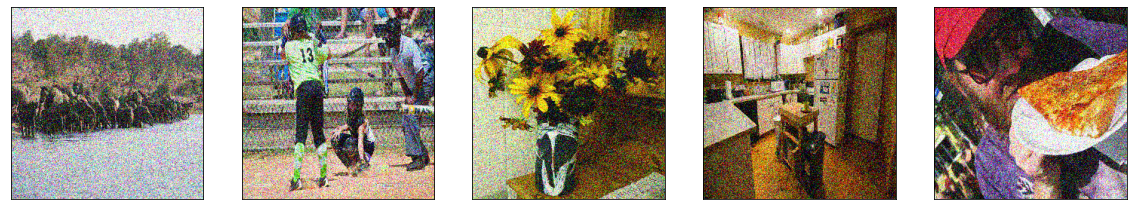

In [6]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

## 4 Création du modèle <a class="anchor" id="chapter5"></a>

<div style="text-align: justify">Nous avons maintenaint un dataset nettoyé et prêt à être exploité pour l'entrainement des modèles. Par conséquent cette partie est axée sur le développement et l'évaluation du modèle.</div>

### 4.1 Autoencodeur <a class="anchor" id = "section_5_1">

<div style="text-align: justify">Cette architecture fonctionne sur la base de 2 concepts qui nous permettront de prendre en entrée une image bruitée :</div><br>

- <strong>Encodeur</strong>: L'objectif de cette étape est de sous-échantillonner l’image en entrée. Pour ce faire, nous allons utiliser des opérations de convolution comme vues précédemment dans le livrable 1. Ce qui aura pour conséquence de réduire la taille de l’image d’entrée. A la suite des opérations de convolution nous obtiendrons une représentation vectorielle de notre image, appelée espace latent.

- <strong>Décodeur</strong>: La seconde partie, appelée décodeur, prend en entrée l’espace latent généré par l’encodeur. Son objectif sera de reconstruire l’image en supprimant le bruit. Pour ce faire, nous utilisons des couches de convolutions transposées. Ces couches vont rééchantillonner l’image à partir des caractéristiques de l’espace latent comme le montre le schéma ci-dessous :

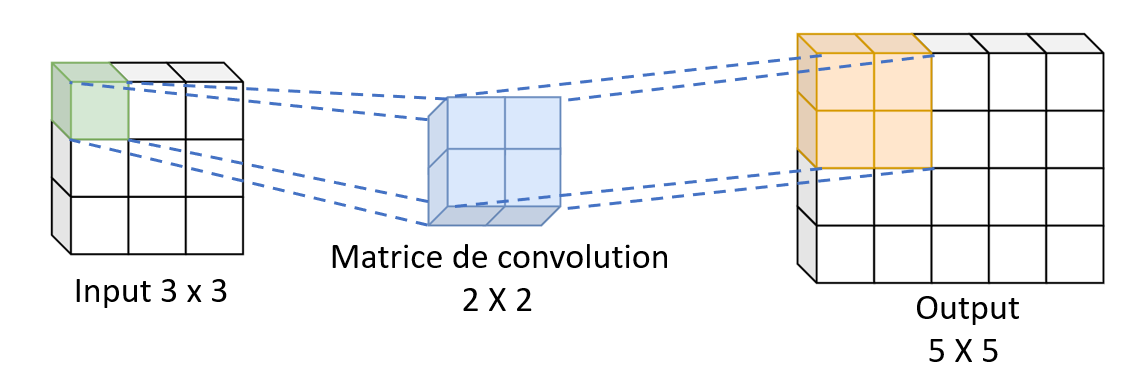
<br>

<div style="text-align: justify">Cette architecture répond parfaitement à la problématique posée précédemment dans le notebook. En effet, nous avons pu diminuer la dimension de manière non-linéaire tout en gardant des performances très acceptables.</div>


### 4.2 Implémentation du modèle <a class="anchor" id = "section_5_2">

<div style="text-align: justify">Dans cette partie nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle telles que le nombre d'épochs ou la taille du batch.</div>

In [7]:
nb_epochs = 1000
batch_size = 18

#### 4.2.1 Définition du modèle <a class="anchor" id = "section_5_2_1">

<div style="text-align: justify">La cellule ci-dessous représente les différentes couches de convolution et de transposé utiles à la reconstruction de l'image. Nous précisons les différentes tailles de filtre et de kernel ainsi que les fonctions d'activation.</div><br>

<div style="text-align: justify">Dans le but de minimiser notre fonction coût nous avons choisi l'optimiseur Adam. Cet algorithme d'optimisation est utilisé pour la formation de modèles d'apprentissage profond. Il s'agit d'une extension de la descente de gradient.</div>

In [8]:
inputs = Input(shape=(image_w, image_w, 3))

#Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
model_opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584

#### 4.2.3 Sauvegarde du meilleur modèle  <a class="anchor" id="section_5_2_3"></a>

<div style="text-align: justify">Une fois les différentes épochs éffectuées nous sauvegardons les poids du meilleur model obtenus durant la phase d'entrainement. Dans la suite du notebook, nous n'aurons plus qu'à charger les poids de ce modèle pour faire des prédictions.</div>

In [9]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./models/new_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

#### 4.2.4 Entrainement du modèle  <a class="anchor" id="section_5_2_4"></a>

Nous pouvons désormais entrainer notre modèle en spécifiant le nombre d'épochs ainsi que la taille du batch défini au préalable. 

In [10]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

Epoch 1/1000
1/1 [==============================] - 24s 24s/step - loss: 0.6931 - val_loss: 0.6943
Epoch 2/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.6895 - val_loss: 0.7834
Epoch 3/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.7615 - val_loss: 0.6913
Epoch 4/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.6911 - val_loss: 0.6916
Epoch 5/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.6923 - val_loss: 0.6912
Epoch 6/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.6919 - val_loss: 0.6905
Epoch 7/1000
1/1 [==============================] - 0s 229ms/step - loss: 0.6911 - val_loss: 0.6880
Epoch 8/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.6896 - val_loss: 0.6831
Epoch 9/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.6864 - val_loss: 0.6788
Epoch 10/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.6803 - val_loss: 0.6609


1/1 [==============================] - 0s 232ms/step - loss: 0.5341 - val_loss: 0.5173
Epoch 83/1000
1/1 [==============================] - 0s 255ms/step - loss: 0.5389 - val_loss: 0.5116
Epoch 84/1000
1/1 [==============================] - 0s 227ms/step - loss: 0.5334 - val_loss: 0.5162
Epoch 85/1000
1/1 [==============================] - 0s 229ms/step - loss: 0.5365 - val_loss: 0.5127
Epoch 86/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.5339 - val_loss: 0.5124
Epoch 87/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5345 - val_loss: 0.5106
Epoch 88/1000
1/1 [==============================] - 0s 243ms/step - loss: 0.5331 - val_loss: 0.5112
Epoch 89/1000
1/1 [==============================] - 0s 261ms/step - loss: 0.5336 - val_loss: 0.5109
Epoch 90/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.5323 - val_loss: 0.5115
Epoch 91/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.5331 - val_loss: 0.5094
Epoc

1/1 [==============================] - 0s 234ms/step - loss: 0.5178 - val_loss: 0.4955
Epoch 163/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.5180 - val_loss: 0.4936
Epoch 164/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.5165 - val_loss: 0.4928
Epoch 165/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.5152 - val_loss: 0.4929
Epoch 166/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5155 - val_loss: 0.4929
Epoch 167/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5160 - val_loss: 0.4935
Epoch 168/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5160 - val_loss: 0.4924
Epoch 169/1000
1/1 [==============================] - 0s 229ms/step - loss: 0.5153 - val_loss: 0.4919
Epoch 170/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.5146 - val_loss: 0.4921
Epoch 171/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5148 - val_loss: 0.

1/1 [==============================] - 0s 231ms/step - loss: 0.5105 - val_loss: 0.4887
Epoch 243/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.5095 - val_loss: 0.4890
Epoch 244/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5102 - val_loss: 0.4891
Epoch 245/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.5105 - val_loss: 0.4887
Epoch 246/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5097 - val_loss: 0.4885
Epoch 247/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5091 - val_loss: 0.4883
Epoch 248/1000
1/1 [==============================] - 0s 228ms/step - loss: 0.5093 - val_loss: 0.4887
Epoch 249/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5099 - val_loss: 0.4885
Epoch 250/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5091 - val_loss: 0.4882
Epoch 251/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5085 - val_loss: 0.

1/1 [==============================] - 0s 234ms/step - loss: 0.5067 - val_loss: 0.4879
Epoch 323/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5072 - val_loss: 0.4866
Epoch 324/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5054 - val_loss: 0.4857
Epoch 325/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.5044 - val_loss: 0.4863
Epoch 326/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5047 - val_loss: 0.4867
Epoch 327/1000
1/1 [==============================] - 0s 229ms/step - loss: 0.5052 - val_loss: 0.4864
Epoch 328/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5051 - val_loss: 0.4860
Epoch 329/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.5044 - val_loss: 0.4858
Epoch 330/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.5041 - val_loss: 0.4858
Epoch 331/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5041 - val_loss: 0.

1/1 [==============================] - 0s 242ms/step - loss: 0.5015 - val_loss: 0.4859
Epoch 403/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.5018 - val_loss: 0.4857
Epoch 404/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.5016 - val_loss: 0.4855
Epoch 405/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5016 - val_loss: 0.4851
Epoch 406/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.5013 - val_loss: 0.4853
Epoch 407/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5013 - val_loss: 0.4852
Epoch 408/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5012 - val_loss: 0.4854
Epoch 409/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.5011 - val_loss: 0.4855
Epoch 410/1000
1/1 [==============================] - 0s 230ms/step - loss: 0.5012 - val_loss: 0.4853
Epoch 411/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.5012 - val_loss: 0.

1/1 [==============================] - 0s 237ms/step - loss: 0.4998 - val_loss: 0.4869
Epoch 483/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4996 - val_loss: 0.4869
Epoch 484/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4994 - val_loss: 0.4861
Epoch 485/1000
1/1 [==============================] - 0s 246ms/step - loss: 0.4993 - val_loss: 0.4857
Epoch 486/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.4990 - val_loss: 0.4865
Epoch 487/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.4990 - val_loss: 0.4865
Epoch 488/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4992 - val_loss: 0.4861
Epoch 489/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.4995 - val_loss: 0.4859
Epoch 490/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4990 - val_loss: 0.4868
Epoch 491/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4993 - val_loss: 0.

1/1 [==============================] - 0s 233ms/step - loss: 0.4976 - val_loss: 0.4879
Epoch 563/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4976 - val_loss: 0.4876
Epoch 564/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4976 - val_loss: 0.4882
Epoch 565/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.4975 - val_loss: 0.4875
Epoch 566/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.4974 - val_loss: 0.4875
Epoch 567/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4972 - val_loss: 0.4876
Epoch 568/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.4971 - val_loss: 0.4879
Epoch 569/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4970 - val_loss: 0.4870
Epoch 570/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4969 - val_loss: 0.4877
Epoch 571/1000
1/1 [==============================] - 0s 245ms/step - loss: 0.4968 - val_loss: 0.

1/1 [==============================] - 0s 231ms/step - loss: 0.4959 - val_loss: 0.4879
Epoch 643/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.4956 - val_loss: 0.4890
Epoch 644/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4955 - val_loss: 0.4883
Epoch 645/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4957 - val_loss: 0.4885
Epoch 646/1000
1/1 [==============================] - 0s 251ms/step - loss: 0.4957 - val_loss: 0.4891
Epoch 647/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4956 - val_loss: 0.4880
Epoch 648/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4957 - val_loss: 0.4895
Epoch 649/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4956 - val_loss: 0.4883
Epoch 650/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.4957 - val_loss: 0.4888
Epoch 651/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4955 - val_loss: 0.

1/1 [==============================] - 0s 236ms/step - loss: 0.4944 - val_loss: 0.4901
Epoch 723/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4944 - val_loss: 0.4894
Epoch 724/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.4943 - val_loss: 0.4893
Epoch 725/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4943 - val_loss: 0.4901
Epoch 726/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4943 - val_loss: 0.4896
Epoch 727/1000
1/1 [==============================] - 0s 239ms/step - loss: 0.4943 - val_loss: 0.4897
Epoch 728/1000
1/1 [==============================] - 0s 241ms/step - loss: 0.4943 - val_loss: 0.4898
Epoch 729/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4943 - val_loss: 0.4902
Epoch 730/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4944 - val_loss: 0.4895
Epoch 731/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.4945 - val_loss: 0.

1/1 [==============================] - 0s 233ms/step - loss: 0.4941 - val_loss: 0.4917
Epoch 803/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4944 - val_loss: 0.4915
Epoch 804/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.4949 - val_loss: 0.4926
Epoch 805/1000
1/1 [==============================] - 0s 236ms/step - loss: 0.4953 - val_loss: 0.4917
Epoch 806/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4956 - val_loss: 0.4930
Epoch 807/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4953 - val_loss: 0.4912
Epoch 808/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4947 - val_loss: 0.4909
Epoch 809/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4939 - val_loss: 0.4909
Epoch 810/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4935 - val_loss: 0.4907
Epoch 811/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4937 - val_loss: 0.

1/1 [==============================] - 0s 236ms/step - loss: 0.4932 - val_loss: 0.4924
Epoch 883/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4933 - val_loss: 0.4919
Epoch 884/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4931 - val_loss: 0.4906
Epoch 885/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4932 - val_loss: 0.4913
Epoch 886/1000
1/1 [==============================] - 0s 242ms/step - loss: 0.4931 - val_loss: 0.4923
Epoch 887/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4932 - val_loss: 0.4917
Epoch 888/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4930 - val_loss: 0.4911
Epoch 889/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4930 - val_loss: 0.4913
Epoch 890/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4929 - val_loss: 0.4916
Epoch 891/1000
1/1 [==============================] - 0s 238ms/step - loss: 0.4929 - val_loss: 0.

1/1 [==============================] - 0s 234ms/step - loss: 0.4922 - val_loss: 0.4924
Epoch 963/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4922 - val_loss: 0.4938
Epoch 964/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4922 - val_loss: 0.4929
Epoch 965/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4922 - val_loss: 0.4930
Epoch 966/1000
1/1 [==============================] - 0s 237ms/step - loss: 0.4921 - val_loss: 0.4936
Epoch 967/1000
1/1 [==============================] - 0s 234ms/step - loss: 0.4921 - val_loss: 0.4928
Epoch 968/1000
1/1 [==============================] - 0s 233ms/step - loss: 0.4921 - val_loss: 0.4935
Epoch 969/1000
1/1 [==============================] - 0s 231ms/step - loss: 0.4921 - val_loss: 0.4934
Epoch 970/1000
1/1 [==============================] - 0s 235ms/step - loss: 0.4921 - val_loss: 0.4930
Epoch 971/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.4921 - val_loss: 0.

#### 4.2.5 Visualisation des résultats <a class="anchor" id="section_5_2_4"></a>

<div style="text-align: justify">La viusalisation des résultats est une partie très intérressante car elle permet de nous donner des indications sur les performances du modèle.</div>

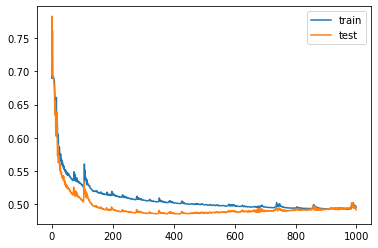

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify">Les courbes ci-dessus représentent l'évolution de la fonction de perte au cours des épochs pour les jeux d'entrainement et de test. Nous pouvons constater que les deux courbes se confondent au fil des épochs. Nous pouvons, par conséquent, en déduire que notre modèle ne sur-apprend pas. </div>

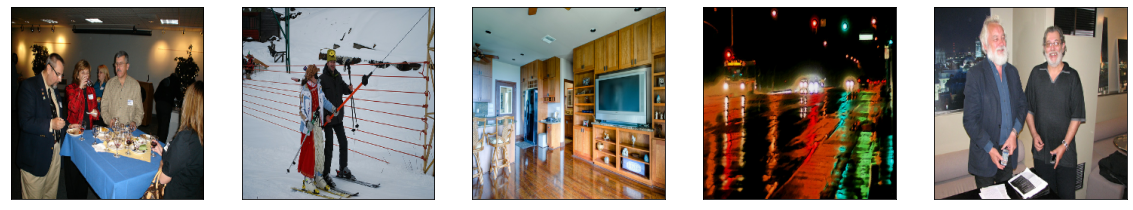

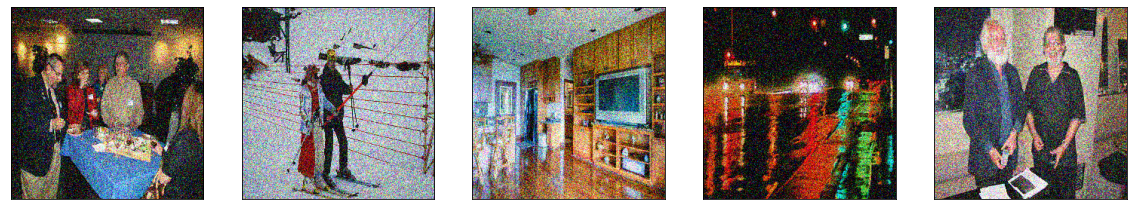

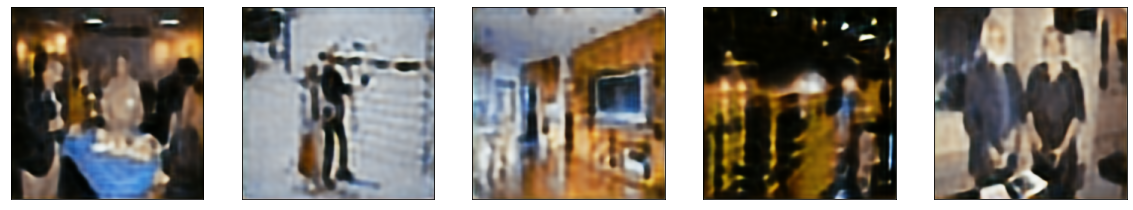

In [12]:
model_dir = pathlib.Path("models//best_model.h5")
model = keras.models.load_model(model_dir)
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

<div style="text-align: justify">Les images qui sont affichées sont le résultat de notre opération de débruitage. Le résultat visuel de notre modèle pouvant être amélioré, nous avons cherché un moyen de l'améliorer. Pour ce faire, nous avons cherché dans la littérature des architectures capable de rendre un résulat qui s'approche plus de nos critères en termes de qualité.</div> 

### 4.3 Amélioration du modèle <a class="anchor" id="section_5_3"></a>

<div style="text-align: justify">Comme dit précedement cette partie a pour but d'augmenter la qualité de nos résultats. Pour cela, nous avons choisi d'implémenter une architecture de DAE (Denoising AutoEncoder) tirée de la littérature.</div> 

#### 4.3.1 Définition des layers <a class="anchor" id="section_5_3_1"></a>

<div style="text-align: justify">Nous définissons les différents layers qui composent le réseau de neurones de l'Autoencodeur. Dans cette architecture nous utilisons un fonction d'activation leaky Relu ainsi que la méthode de batch normalization qui sont intéressantes d'expliquer.</div><br>

<div style="text-align: justify"><strong>Leaky Relu:</strong>Il s'agit d'une fonction d'activation qui se base sur RELU, mais elle a une petite pente pour les valeurs négatives au lieu d'une pente plate. Le coefficient de pente est déterminé avant l'entrainement et ajuster au cours des époques. Comme le montre la représentation ci-dessous.</div> 

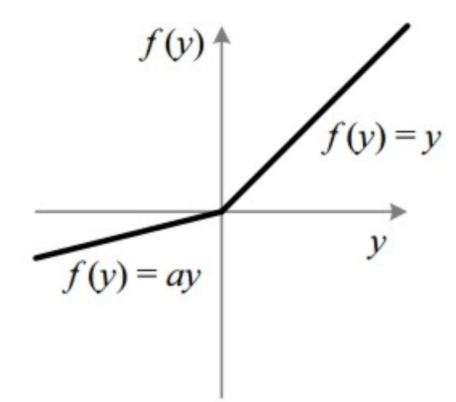
<br>
<div style="text-align: justify"><strong>Batch Normalization:</strong>il s'agit d'une méthode utilisée pour rendre le réseau de neurones artificiels plus rapide et plus stable en normalisant les données à l'entrée des couches.</div> 

In [13]:
#Encodeur
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

<div style="text-align: justify"><strong>Conv2DTranspose()</strong> est une opération de convolution dont le noyau est appris (tout comme l'opération conv2d normale) lors de l'entraînement de notre modèle. L'utilisation de Conv2DTranspose suréchantillonnera également son entrée, mais la principale différence est que le modèle doit apprendre quel est le meilleur suréchantillonnage pour sa tache.</div>

In [14]:
#Décodeur
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

#### 4.3.2 Définition du modèle  <a class="anchor" id="section_5_3_2"></a>

Nous définissons et entrainons notre modèle de la même manière que le précedent. 

In [15]:
def AutoEncoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

model = AutoEncoder((image_h, image_w, 3))
model_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])

Dans le but de donner un meilleur aperçu du modèle mis en place, nous pouvons nous référer au schéma ci-dessous: 

#### 4.3.3 Sauvegarde du meilleur modèle  <a class="anchor" id="section_5_3_3"></a>

In [16]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath=pathlib.Path("models_improved//new_model.h5"), verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

#### 4.3.3 Entrainement du modèle <a class="anchor" id="section_5_3_3"></a>

In [17]:
history = model.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=18,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list_improved
)

Epoch 1/1000
1/1 [==============================] - 9s 9s/step - loss: 0.7907 - accuracy: 0.3077 - val_loss: 0.6985 - val_accuracy: 0.3192
Epoch 2/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.5889 - accuracy: 0.3601 - val_loss: 2.0829 - val_accuracy: 0.3013
Epoch 3/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.5780 - accuracy: 0.4025 - val_loss: 18.1373 - val_accuracy: 0.2951
Epoch 4/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.5653 - accuracy: 0.4469 - val_loss: 52.1107 - val_accuracy: 0.2950
Epoch 5/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.5513 - accuracy: 0.4579 - val_loss: 411.6952 - val_accuracy: 0.2951
Epoch 6/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.5457 - accuracy: 0.4995 - val_loss: 951.4290 - val_accuracy: 0.2951
Epoch 7/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.5432 - accuracy: 0.4990 - val_loss: 1416.6135 - val_accuracy: 0.2950


Epoch 58/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.5062 - accuracy: 0.6182 - val_loss: 5.0665 - val_accuracy: 0.2885
Epoch 59/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.5061 - accuracy: 0.6189 - val_loss: 4.6865 - val_accuracy: 0.2810
Epoch 60/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.5059 - accuracy: 0.6195 - val_loss: 4.4262 - val_accuracy: 0.2796
Epoch 61/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.5058 - accuracy: 0.6213 - val_loss: 4.2182 - val_accuracy: 0.2769
Epoch 62/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.5056 - accuracy: 0.6231 - val_loss: 3.9313 - val_accuracy: 0.2759
Epoch 63/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.5054 - accuracy: 0.6239 - val_loss: 3.6411 - val_accuracy: 0.2796
Epoch 64/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.5053 - accuracy: 0.6227 - val_loss: 3.4094 - val_accuracy: 0.2835

1/1 [==============================] - 0s 454ms/step - loss: 0.5002 - accuracy: 0.6754 - val_loss: 0.5809 - val_accuracy: 0.5583
Epoch 116/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.5001 - accuracy: 0.6728 - val_loss: 0.5803 - val_accuracy: 0.5577
Epoch 117/1000
1/1 [==============================] - 0s 454ms/step - loss: 0.5000 - accuracy: 0.6721 - val_loss: 0.5791 - val_accuracy: 0.5596
Epoch 118/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.5000 - accuracy: 0.6767 - val_loss: 0.5772 - val_accuracy: 0.5531
Epoch 119/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4999 - accuracy: 0.6778 - val_loss: 0.5759 - val_accuracy: 0.5376
Epoch 120/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4998 - accuracy: 0.6768 - val_loss: 0.5750 - val_accuracy: 0.5297
Epoch 121/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4997 - accuracy: 0.6781 - val_loss: 0.5743 - val_accuracy: 0.5357
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4975 - accuracy: 0.7131 - val_loss: 0.5896 - val_accuracy: 0.5116
Epoch 173/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4975 - accuracy: 0.7151 - val_loss: 0.5886 - val_accuracy: 0.5118
Epoch 174/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4974 - accuracy: 0.7113 - val_loss: 0.5884 - val_accuracy: 0.5121
Epoch 175/1000
1/1 [==============================] - 0s 450ms/step - loss: 0.4974 - accuracy: 0.7163 - val_loss: 0.5888 - val_accuracy: 0.5122
Epoch 176/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4974 - accuracy: 0.7143 - val_loss: 0.5885 - val_accuracy: 0.5124
Epoch 177/1000
1/1 [==============================] - 0s 452ms/step - loss: 0.4973 - accuracy: 0.7161 - val_loss: 0.5880 - val_accuracy: 0.5125
Epoch 178/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4974 - accuracy: 0.7193 - val_loss: 0.5881 - val_accuracy:

Epoch 229/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4961 - accuracy: 0.7454 - val_loss: 0.5759 - val_accuracy: 0.5175
Epoch 230/1000
1/1 [==============================] - 0s 450ms/step - loss: 0.4960 - accuracy: 0.7468 - val_loss: 0.5756 - val_accuracy: 0.5175
Epoch 231/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4960 - accuracy: 0.7447 - val_loss: 0.5749 - val_accuracy: 0.5172
Epoch 232/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4960 - accuracy: 0.7442 - val_loss: 0.5747 - val_accuracy: 0.5172
Epoch 233/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4960 - accuracy: 0.7471 - val_loss: 0.5748 - val_accuracy: 0.5174
Epoch 234/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4960 - accuracy: 0.7470 - val_loss: 0.5744 - val_accuracy: 0.5175
Epoch 235/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4959 - accuracy: 0.7451 - val_loss: 0.5742 - val_accuracy:

Epoch 286/1000
1/1 [==============================] - 0s 451ms/step - loss: 0.4951 - accuracy: 0.7579 - val_loss: 0.5575 - val_accuracy: 0.5256
Epoch 287/1000
1/1 [==============================] - 0s 452ms/step - loss: 0.4951 - accuracy: 0.7601 - val_loss: 0.5565 - val_accuracy: 0.5259
Epoch 288/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4952 - accuracy: 0.7660 - val_loss: 0.5567 - val_accuracy: 0.5269
Epoch 289/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4951 - accuracy: 0.7605 - val_loss: 0.5562 - val_accuracy: 0.5277
Epoch 290/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4951 - accuracy: 0.7622 - val_loss: 0.5553 - val_accuracy: 0.5276
Epoch 291/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4951 - accuracy: 0.7644 - val_loss: 0.5555 - val_accuracy: 0.5277
Epoch 292/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4950 - accuracy: 0.7627 - val_loss: 0.5552 - val_accuracy:

Epoch 343/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4944 - accuracy: 0.7703 - val_loss: 0.5349 - val_accuracy: 0.5660
Epoch 344/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4945 - accuracy: 0.7758 - val_loss: 0.5359 - val_accuracy: 0.5726
Epoch 345/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4945 - accuracy: 0.7749 - val_loss: 0.5365 - val_accuracy: 0.5798
Epoch 346/1000
1/1 [==============================] - 0s 451ms/step - loss: 0.4944 - accuracy: 0.7714 - val_loss: 0.5344 - val_accuracy: 0.5717
Epoch 347/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4944 - accuracy: 0.7731 - val_loss: 0.5346 - val_accuracy: 0.5664
Epoch 348/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4944 - accuracy: 0.7803 - val_loss: 0.5356 - val_accuracy: 0.5684
Epoch 349/1000
1/1 [==============================] - 0s 456ms/step - loss: 0.4944 - accuracy: 0.7778 - val_loss: 0.5326 - val_accuracy:

Epoch 400/1000
1/1 [==============================] - 0s 469ms/step - loss: 0.4939 - accuracy: 0.7832 - val_loss: 0.5149 - val_accuracy: 0.6526
Epoch 401/1000
1/1 [==============================] - 0s 453ms/step - loss: 0.4938 - accuracy: 0.7863 - val_loss: 0.5153 - val_accuracy: 0.6671
Epoch 402/1000
1/1 [==============================] - 0s 476ms/step - loss: 0.4939 - accuracy: 0.7863 - val_loss: 0.5142 - val_accuracy: 0.6584
Epoch 403/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4938 - accuracy: 0.7879 - val_loss: 0.5146 - val_accuracy: 0.6470
Epoch 404/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4938 - accuracy: 0.7855 - val_loss: 0.5135 - val_accuracy: 0.6537
Epoch 405/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4938 - accuracy: 0.7868 - val_loss: 0.5144 - val_accuracy: 0.6676
Epoch 406/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4938 - accuracy: 0.7826 - val_loss: 0.5128 - val_accuracy:

Epoch 457/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4933 - accuracy: 0.7899 - val_loss: 0.4971 - val_accuracy: 0.7231
Epoch 458/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4933 - accuracy: 0.7928 - val_loss: 0.4979 - val_accuracy: 0.7254
Epoch 459/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4933 - accuracy: 0.7921 - val_loss: 0.4970 - val_accuracy: 0.7127
Epoch 460/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4933 - accuracy: 0.7892 - val_loss: 0.4967 - val_accuracy: 0.7135
Epoch 461/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4933 - accuracy: 0.7928 - val_loss: 0.4972 - val_accuracy: 0.7219
Epoch 462/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4933 - accuracy: 0.7902 - val_loss: 0.4969 - val_accuracy: 0.7169
Epoch 463/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4933 - accuracy: 0.7921 - val_loss: 0.4948 - val_accuracy:

Epoch 514/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4929 - accuracy: 0.8005 - val_loss: 0.4868 - val_accuracy: 0.7491
Epoch 515/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4929 - accuracy: 0.8006 - val_loss: 0.4845 - val_accuracy: 0.7460
Epoch 516/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4929 - accuracy: 0.7970 - val_loss: 0.4848 - val_accuracy: 0.7466
Epoch 517/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4929 - accuracy: 0.8007 - val_loss: 0.4865 - val_accuracy: 0.7471
Epoch 518/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4929 - accuracy: 0.7993 - val_loss: 0.4844 - val_accuracy: 0.7434
Epoch 519/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4929 - accuracy: 0.8002 - val_loss: 0.4852 - val_accuracy: 0.7437
Epoch 520/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4928 - accuracy: 0.8027 - val_loss: 0.4853 - val_accuracy:

Epoch 571/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4924 - accuracy: 0.8058 - val_loss: 0.4785 - val_accuracy: 0.7570
Epoch 572/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4924 - accuracy: 0.7986 - val_loss: 0.4789 - val_accuracy: 0.7602
Epoch 573/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4924 - accuracy: 0.8021 - val_loss: 0.4781 - val_accuracy: 0.7636
Epoch 574/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4924 - accuracy: 0.8056 - val_loss: 0.4781 - val_accuracy: 0.7511
Epoch 575/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4924 - accuracy: 0.8057 - val_loss: 0.4791 - val_accuracy: 0.7572
Epoch 576/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4924 - accuracy: 0.8051 - val_loss: 0.4783 - val_accuracy: 0.7672
Epoch 577/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4924 - accuracy: 0.7987 - val_loss: 0.4782 - val_accuracy:

Epoch 628/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4920 - accuracy: 0.8050 - val_loss: 0.4757 - val_accuracy: 0.7615
Epoch 629/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4919 - accuracy: 0.8086 - val_loss: 0.4751 - val_accuracy: 0.7568
Epoch 630/1000
1/1 [==============================] - 0s 450ms/step - loss: 0.4919 - accuracy: 0.8077 - val_loss: 0.4752 - val_accuracy: 0.7684
Epoch 631/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4919 - accuracy: 0.8094 - val_loss: 0.4761 - val_accuracy: 0.7694
Epoch 632/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4919 - accuracy: 0.8051 - val_loss: 0.4742 - val_accuracy: 0.7571
Epoch 633/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4920 - accuracy: 0.8101 - val_loss: 0.4749 - val_accuracy: 0.7661
Epoch 634/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4919 - accuracy: 0.8073 - val_loss: 0.4753 - val_accuracy:

Epoch 685/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4914 - accuracy: 0.8145 - val_loss: 0.4737 - val_accuracy: 0.7536
Epoch 686/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4914 - accuracy: 0.8155 - val_loss: 0.4732 - val_accuracy: 0.7701
Epoch 687/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4914 - accuracy: 0.8105 - val_loss: 0.4742 - val_accuracy: 0.7555
Epoch 688/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4914 - accuracy: 0.8102 - val_loss: 0.4730 - val_accuracy: 0.7662
Epoch 689/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4914 - accuracy: 0.8137 - val_loss: 0.4738 - val_accuracy: 0.7614
Epoch 690/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4913 - accuracy: 0.8135 - val_loss: 0.4732 - val_accuracy: 0.7617
Epoch 691/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4913 - accuracy: 0.8125 - val_loss: 0.4726 - val_accuracy:

Epoch 742/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4909 - accuracy: 0.8129 - val_loss: 0.4726 - val_accuracy: 0.7543
Epoch 743/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4908 - accuracy: 0.8193 - val_loss: 0.4725 - val_accuracy: 0.7646
Epoch 744/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4908 - accuracy: 0.8182 - val_loss: 0.4729 - val_accuracy: 0.7738
Epoch 745/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4908 - accuracy: 0.8174 - val_loss: 0.4723 - val_accuracy: 0.7565
Epoch 746/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4908 - accuracy: 0.8159 - val_loss: 0.4723 - val_accuracy: 0.7550
Epoch 747/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4908 - accuracy: 0.8142 - val_loss: 0.4731 - val_accuracy: 0.7653
Epoch 748/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4908 - accuracy: 0.8197 - val_loss: 0.4729 - val_accuracy:

Epoch 799/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4903 - accuracy: 0.8177 - val_loss: 0.4724 - val_accuracy: 0.7571
Epoch 800/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4903 - accuracy: 0.8207 - val_loss: 0.4725 - val_accuracy: 0.7660
Epoch 801/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4903 - accuracy: 0.8187 - val_loss: 0.4717 - val_accuracy: 0.7593
Epoch 802/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4903 - accuracy: 0.8181 - val_loss: 0.4714 - val_accuracy: 0.7637
Epoch 803/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4903 - accuracy: 0.8230 - val_loss: 0.4728 - val_accuracy: 0.7652
Epoch 804/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4903 - accuracy: 0.8251 - val_loss: 0.4716 - val_accuracy: 0.7627
Epoch 805/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4903 - accuracy: 0.8183 - val_loss: 0.4711 - val_accuracy:

Epoch 856/1000
1/1 [==============================] - 0s 444ms/step - loss: 0.4898 - accuracy: 0.8238 - val_loss: 0.4715 - val_accuracy: 0.7589
Epoch 857/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4898 - accuracy: 0.8234 - val_loss: 0.4712 - val_accuracy: 0.7617
Epoch 858/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4898 - accuracy: 0.8273 - val_loss: 0.4714 - val_accuracy: 0.7622
Epoch 859/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4897 - accuracy: 0.8256 - val_loss: 0.4711 - val_accuracy: 0.7592
Epoch 860/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4898 - accuracy: 0.8227 - val_loss: 0.4715 - val_accuracy: 0.7649
Epoch 861/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4898 - accuracy: 0.8251 - val_loss: 0.4713 - val_accuracy: 0.7598
Epoch 862/1000
1/1 [==============================] - 0s 448ms/step - loss: 0.4898 - accuracy: 0.8266 - val_loss: 0.4712 - val_accuracy:

Epoch 913/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4894 - accuracy: 0.8265 - val_loss: 0.4707 - val_accuracy: 0.7648
Epoch 914/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4894 - accuracy: 0.8260 - val_loss: 0.4706 - val_accuracy: 0.7593
Epoch 915/1000
1/1 [==============================] - 0s 445ms/step - loss: 0.4893 - accuracy: 0.8242 - val_loss: 0.4716 - val_accuracy: 0.7587
Epoch 916/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4894 - accuracy: 0.8312 - val_loss: 0.4708 - val_accuracy: 0.7540
Epoch 917/1000
1/1 [==============================] - 0s 447ms/step - loss: 0.4893 - accuracy: 0.8297 - val_loss: 0.4703 - val_accuracy: 0.7574
Epoch 918/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4894 - accuracy: 0.8236 - val_loss: 0.4708 - val_accuracy: 0.7615
Epoch 919/1000
1/1 [==============================] - 0s 446ms/step - loss: 0.4893 - accuracy: 0.8264 - val_loss: 0.4707 - val_accuracy:

Epoch 970/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4890 - accuracy: 0.8312 - val_loss: 0.4703 - val_accuracy: 0.7535
Epoch 971/1000
1/1 [==============================] - 0s 457ms/step - loss: 0.4890 - accuracy: 0.8303 - val_loss: 0.4706 - val_accuracy: 0.7547
Epoch 972/1000
1/1 [==============================] - 0s 449ms/step - loss: 0.4890 - accuracy: 0.8281 - val_loss: 0.4707 - val_accuracy: 0.7637
Epoch 973/1000
1/1 [==============================] - 0s 467ms/step - loss: 0.4890 - accuracy: 0.8275 - val_loss: 0.4704 - val_accuracy: 0.7562
Epoch 974/1000
1/1 [==============================] - 1s 508ms/step - loss: 0.4890 - accuracy: 0.8317 - val_loss: 0.4704 - val_accuracy: 0.7531
Epoch 975/1000
1/1 [==============================] - 1s 512ms/step - loss: 0.4890 - accuracy: 0.8266 - val_loss: 0.4710 - val_accuracy: 0.7562
Epoch 976/1000
1/1 [==============================] - 1s 504ms/step - loss: 0.4889 - accuracy: 0.8314 - val_loss: 0.4709 - val_accuracy:

#### 4.3.4 Visualisation des résultats <a class="anchor" id="section_5_3_4"></a>

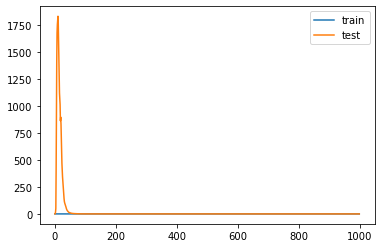

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify"> Nous pouvons voir que les résultats obtenus sont nettement supérieurs à ceux obtenus précedemment et nous paraissent, à première vue, satisfaisant. En effet, sur cette architecture la valeur de la fonction de perte est bien moins élevée que sur notre premier modèle. De plus, nous ne décelons aucune trace de sur-appretissage. Pour nous assurer de cette première impression, nous avons voulu user de metriques pouvant confirmer notre analyse.</div>

## 5. Evaluation des performances de l'autoencodeur <a class="anchor" id="chapter6"></a>

<div style="text-align: justify"> Notre autoencodeur est capable de débruiter toute image bruitée avec un résultat à l'oeil nu convaincant. Evaluons à présent les performances de cet autoencodeur à l'aide de différentes métriques.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter la <strong>MSE</strong> et le <strong>SSIM</strong></div>.

- MSE : <div style="text-align: justify">Mean-square error ou erreur moyenne quadratique est un estimateur d'erreur traditionnel. La MSE mesure,dans notre cas, la différence moyenne au carré entre les images prédites et les images originales. Il suffit donc de calculer les différences entre les images pixel par pixel. Mais cela ne fonctionne bien que si nous voulons générer une image avec les meilleures couleurs de pixel conformes à l'image de base. Dans notre cas, nous voulons nous concentrer sur la structure ou le relief de l'image pour évaluer notre autoencodeur.</div>

Pour pallier ce problème nous avons implémenté également le SSIM.

- SSIM : <div style="text-align: justify">Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.</div>

### 5.1 Import des images

Nous importons trois images : 
- une image originale
- une image bruitée
- une image générée par l'autoencodeur depuis cette même image bruitée

In [19]:
size = (226,226)
#On importe et redimensionne notre image de base, la même image bruitée et l'image générée par notre denoiser
img1 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_base.png")
img_resize1 = img1.resize(size)
img = img_as_float(img_resize1)

img2 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_noise.png")
img_resize2 = img2.resize(size)
img_noise = img_as_float(img_resize2)

img3 = Image.open(r"C:\Users\jbcst\OneDrive\Bureau\img_final.png")
img_resize3 = img3.resize(size)
img_const = img_as_float(img_resize3)

### 5.2 Implémentation de la MSE et du SSIM

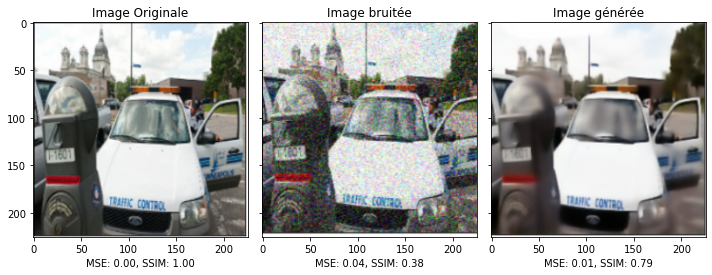

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min(), multichannel=True)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min(), multichannel=True)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min(), multichannel=True)

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
ax[0].set_title('Image Originale')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image bruitée')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
ax[2].set_title('Image générée')

plt.tight_layout()
plt.show()

### 5.3 Interprétation des résultats

<div style="text-align: justify">Nous affichons les valeurs de MSE et de SSIM pour chacune de nos images. Le but étant d'avoir la MSE la plus proche de 0 et  une valeur de SSIM la plus proche de 1 possible. Nous voyons donc que notre valeur de MSE pour notre image générée est de 0,01 donc proche de 0, cependant la MSE de l'image bruitée est de 0,04 donc nous ne pouvons pas nous baser sur cette valeur pour évaluer notre modèle.<br>
    
Voyons voir du coté du SSIM : <br> 
    
Nous avons une valeur de 0,79 pour l'image générée et une valeur de 0,38 pour l'image bruitée. Nous pouvons en conclure que, pour notre modèle, l'image générée est très similaire à l'image d'origine.</div>

## 6. Etude de cas <a class="anchor" id="chapter7"></a>

<div style="text-align: justify">Dans le but d'attester des bonnes performances de notre modèle nous avons decidé de réaliser une étude de cas. Nous nous centrerons sur le traitement d'une image bruitée que nous devrons importer et convertir dans le but de la rendre exploitable par le modèle. Nous passerons l'image bruitée en entrée de notre modèle et analyserons la sortie.</div>

### 6.1 Chargement de l'image 

<div style="text-align: justify">Dans un premier temps, nous devons importer notre image dans le notebook. Pour nous assurer de la véracité des résultats de notre étude nous avons choisi une image tirée d'internet bruitée au préalable. Le code ci-dessous appelle la fonction "prepocess" utilisée pour convertir et normaliser l'image en entrée.</div> 

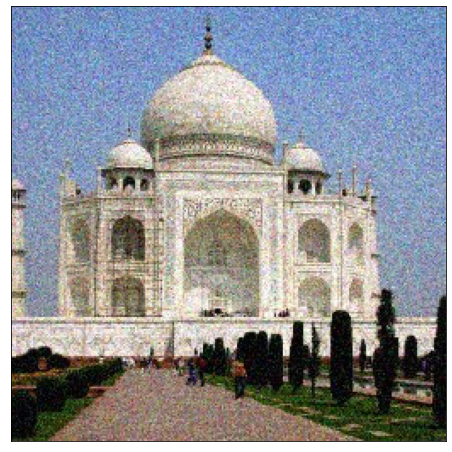

In [21]:
img = image.load_img("taj-rgb-noise.jpg", target_size=(256, 256))
img_convert = preprocess(img, is_batch = False)
display_image(img_convert, n=1, size = 8)

### 6.2 Débruitage de la photo

<div style="text-align: justify">Nous allons pouvoir maintenant passer notre photo dans l'algorithme afin qu'elle puisse se faire débruiter. Pour ce faire nous avons au préalable sauvegardé les poids de notre modèle dans le but d'optimiser le processus en terme de temps.</div>

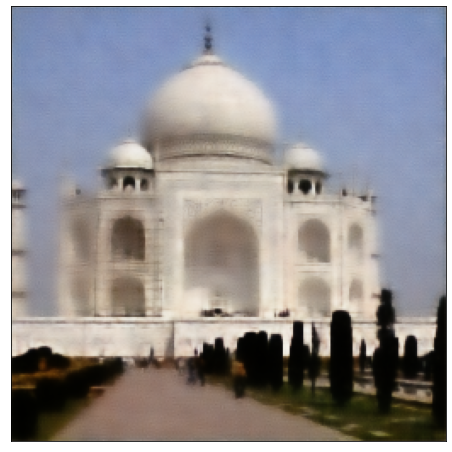

In [22]:
model_dir = pathlib.Path("models_improved//best_model.h5")
model = tf.keras.models.load_model(model_dir)
predictions = model.predict(img_convert)
display_image(predictions, 1, size=8)

<div style="text-align: justify">La sortie de notre DAE nous semble correcte. En effet, nous arrivons à reconnaitre le Tajmal et distinguons le paysage environnant. Néanmoins, nous constatons une perte de précision par rapport à l'image initiale que nous avons quantifiée dans la partie <strong>5. Mesure de la performance du modèle</strong>. Cette perte d'information se matérialise par l'apparition de flou sur la photo.</div>

## 7. Conclusion 

<div style="text-align: justify">L'objectif de ce notebook était de débruiter une image afin de la rendre utilisable par les algorithmes de Machine Learning. Pour ce faire nous avons pu nous reposer sur les acquis du livrable 1 en terme d'import de blibliothèques et d'utilisation du GPU. Néanmoins, pour préparer notre dataset il a fallu bruiter nos données pour pouvoir entrainer notre modèle. Suite à cela nous avons du chercher un modèle qui correspond à notre problème et nos contraintes.</div><br>

<div style="text-align: justify">Notre choix s'est dirigé tout naturellement vers l'Autoencodeur. Néanmoins, après avoir testé de nombreuses combinaisons de couche et de filtre, nos résultats n'étaient pas à la hauteur de nos attentes. Dans le but d'améliorer nos résultats, nous avons cherché et trouvé une achitecture tirée de la littérature que nous avons implémenté. Les résultats qui en découlent sont bons et sont confirmés par notre étude de performance. Pour finir, nous avons décidé de réaliser une étude de cas pour attester nos résultats.</div>